## Goals:

1. Find maximum-likelihood parameters for a model using gradient descent algorithms (based on SSE or LL)
2. Model comparison using AIC and BIC
3. Model and parameter recovery

## Load packages

In [1]:
import os, sys, glob, scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
base_dir = os.path.realpath('.')
print(base_dir)

/Users/jvanbaar/Dropbox (Brown)/Postdoc FHL/Teaching/Computational_modeling_tutorial


## Writing choice rules

In [3]:
def greedy(utilities, params = []):
    
    choice = np.where(utilities == np.max(utilities))[0][0]
    
    return choice

In [4]:
def e_greedy(utilities, epsilon):
    
    random_number = np.random.rand()
    
    if random_number < epsilon:
        # Choose randomly
        choice = np.random.randint(0,2)
    else:
        # Choose deterministically
#         choice = np.where(utilites == np.max(utilities))
        choice = greedy(utilities)
    
    return choice

In [5]:
def softmax_with_choice(utilities, beta):
    # Beta is sometimes called 'inverse temperature' or 'explore parameter'
    
    # Version for choice A only => then prob_B will be 1 - prob_A
    prob_A = (np.exp(utilities[0] * beta) /
              (np.exp(utilities[0] * beta) + np.exp(utilities[1] * beta)))
    
    # General version (this works too, try it out!)
    probs = (np.exp(np.multiply(utilities, beta)) /
             (np.sum(np.exp(np.multiply(utilities, beta)))))
    
    random_number = np.random.rand()
    if random_number < prob_A:
        choice = 0
    else:
        choice = 1
    
    return choice

In [6]:
def softmax(utilities, beta):

    probs = (np.exp(np.multiply(utilities, beta)) /
             (np.sum(np.exp(np.multiply(utilities, beta)))))
    
    return probs

##### Define our inequity aversion model again:

In [7]:
def inequity_aversion(offer, alpha):
    
    # Inequity aversion model with one inequity term (= symmetric) and a money term
    payoffs = np.array([offer, 0])
    inequities = np.array([(100-offer)-offer, 0])
    utilities = payoffs - np.multiply(alpha,inequities)

    return utilities

##### Simulate data for inequity aversion + softmax with varying parameter values

In [8]:
def simulate_data(sub_data, alpha, beta):
    simulated_data = pd.DataFrame(columns=['trial', 'offer', 'probability_accept'])
    for trial in sub_data['trial'].unique():
        trial_data = sub_data.query('trial == @trial')
        offer = trial_data['offer'].values[0]
        
        # Value function: inequity aversion ==> utilities
        utilities = inequity_aversion(offer, alpha)
        
        # Choice rule: softmax ==> probabilities
        choice_probabilities = softmax(utilities, beta)
        
        # Store results
        simulated_data = simulated_data.append(pd.DataFrame(
            [[trial, offer, choice_probabilities[0]]], columns = simulated_data.columns)).reset_index(drop=True)
    return simulated_data

## Using the SciPy package to fit the model for us

1. Load Joey's data again
2. Tell the SciPy.Optimise. to find the best fitting parameters

##### Load some data

In [9]:
data = pd.read_csv(base_dir + '/Data/Study1_UG.csv')
data = data[['sub','trial','unfairness','choice']]
data['offer'] = 100 - data['unfairness']
data.head()

,sub,trial,unfairness,choice,offer
0,1,1,50,0,50
1,1,2,80,0,20
2,1,3,95,0,5
3,1,4,60,0,40
4,1,5,75,0,25


Single subject:

In [10]:
sub = 2
sub_data = data.query('sub == @sub').reset_index(drop=True)
sub_data.head()

,sub,trial,unfairness,choice,offer
0,2,1,60,0,40
1,2,2,55,0,45
2,2,3,85,1,15
3,2,4,95,1,5
4,2,5,65,0,35


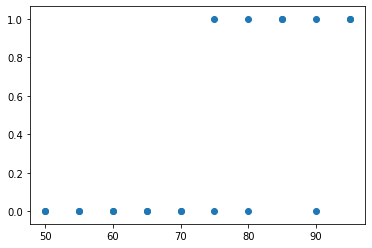

In [11]:
plt.scatter(sub_data['unfairness'], sub_data['choice'])

##### Implement the optimization routine

In [12]:
def compute_negloglike(params, data):
    
    alpha = params[0]
    beta = params[1]
    
    # For each trial, compute the probability of observing THIS PARTICULAR BEHAVIOR given alpha and beta
    trial_probs = []
    for trial in data['trial'].unique():
        trial_data = data.query('trial == @trial')
        offer = trial_data['offer'].values[0]
        choice = trial_data['choice'].values[0]
        utilities = inequity_aversion(offer, alpha)
        choice_probabilities = softmax(utilities, beta)
        prob_of_observed = choice_probabilities[choice]
        trial_probs.append(prob_of_observed)
    
    # Multiply the probabilities of all trials to get the likelihood of the whole dataset –– here use the log trick!
    loglike = np.sum(np.log(trial_probs))
    
    return -loglike

In [13]:
import tqdm

In [14]:
n_iter = 10
objective_function = lambda params: compute_negloglike(params, sub_data)
fit_results = pd.DataFrame()
for i in tqdm.tqdm(range(n_iter)):
    x0 = np.random.rand(2)
    out = scipy.optimize.fmin(objective_function, x0, full_output=True)
    best_params, best_NLL = out[:2]
    fit_results = fit_results.append(pd.DataFrame([[i, best_params, best_NLL]],
                                     columns = ['iteration','best_params','best_NLL']))

 10%|█         | 1/10 [00:02<00:22,  2.52s/it]

Optimization terminated successfully.
         Current function value: 6.392669
         Iterations: 42
         Function evaluations: 81


 20%|██        | 2/10 [00:04<00:18,  2.33s/it]

Optimization terminated successfully.
         Current function value: 6.392669
         Iterations: 31
         Function evaluations: 59


 30%|███       | 3/10 [00:06<00:16,  2.29s/it]

Optimization terminated successfully.
         Current function value: 6.392669
         Iterations: 36
         Function evaluations: 68


 40%|████      | 4/10 [00:08<00:13,  2.22s/it]

Optimization terminated successfully.
         Current function value: 6.392669
         Iterations: 38
         Function evaluations: 73


 50%|█████     | 5/10 [00:11<00:12,  2.45s/it]

Optimization terminated successfully.
         Current function value: 6.392668
         Iterations: 51
         Function evaluations: 97


 60%|██████    | 6/10 [00:15<00:10,  2.74s/it]

Optimization terminated successfully.
         Current function value: 6.392669
         Iterations: 43
         Function evaluations: 83


 70%|███████   | 7/10 [00:17<00:08,  2.74s/it]

Optimization terminated successfully.
         Current function value: 6.392669
         Iterations: 38
         Function evaluations: 73


 80%|████████  | 8/10 [00:20<00:05,  2.66s/it]

Optimization terminated successfully.
         Current function value: 6.392669
         Iterations: 34
         Function evaluations: 63


 90%|█████████ | 9/10 [00:22<00:02,  2.64s/it]

Optimization terminated successfully.
         Current function value: 6.392669
         Iterations: 40
         Function evaluations: 75


100%|██████████| 10/10 [00:25<00:00,  2.57s/it]

Optimization terminated successfully.
         Current function value: 6.392669
         Iterations: 44
         Function evaluations: 83


In [16]:
fit_results.sort_values(by='best_NLL')

,iteration,best_params,best_NLL
0,4,"[0.32890087483886776, 0.11684241888083689]",6.392668
0,8,"[0.32890205253536675, 0.1168588921941674]",6.392669
0,0,"[0.32889000856217804, 0.11686632280656636]",6.392669
0,5,"[0.3288499453041194, 0.1168621759008255]",6.392669
0,2,"[0.3288563430615493, 0.11684326866808417]",6.392669
0,7,"[0.3288602574215953, 0.11683971959432654]",6.392669
0,3,"[0.3289131943108281, 0.11684018315539903]",6.392669
0,6,"[0.3288350335293181, 0.11686596363537857]",6.392669
0,1,"[0.32892608529911516, 0.11683956881099716]",6.392669
0,9,"[0.32883625212046597, 0.11684374703687117]",6.392669


## Say you want to send this data to the GitHub repository for others to see

In [18]:
base_dir

'/Users/jvanbaar/Dropbox (Brown)/Postdoc FHL/Teaching/Computational_modeling_tutorial'

In [20]:
# Contents of current directory:
!ls

0.Sandbox_problems.ipynb
0.Sandbox_solutions.ipynb
1.Defining_a_model.ipynb
2.Fitting_a_model.ipynb
3.Choice_rules_and_likelihood.ipynb
4.Automating_model_fitting_and_model_comparison.ipynb
Data
LICENSE
README.md
dont_use_data


In [22]:
# Make a folder called 'Results'
!mkdir Results

In [25]:
fit_results.to_csv(base_dir + '/Results/fit_onesub_jeroen.csv')

Now use git command line or GitHub Desktop to push this file to the repo (outside of notebook)

## Find the best-fitting parameters for all subjects using scipy.optimize.fmin

Homework:
1. Fit model for all subjects - find a good number of iterations to try
2. Plot the best-fitting parameters for all subjects
3. Do parameter recovery: a) pick 10 sets of parameters (alpha & beta), b) simulate data for each set, c) fit the model to the simulated data, d) repeat b and c 100 times, e) compare the 'recovered' parameters to the ones you picked in step a).

## Next:

1. Talk about model comparison between model classes (first inequity aversion model vs random choice model using log likelihood, then if we want hidden multiplier trust game social preference models using sum of squared error)
2. Summarize what we've seen so far. Take a step back and talk about why it's useful what we've done and what we're still lacking. What do we still need?
3. Other model types - RL, DDM etc